# Synthetic Audio Detector

Building a Synthetic Audio Detector using Convolutional Neural Networks.

The dataset used is the 2 seconds version of the [Fake or Real (FoR)](https://www.kaggle.com/datasets/mohammedabdeldayem/the-fake-or-real-dataset?resource=download-directory) dataset which aggregates real and synthetic audio from various sources. You can read more about it on the Kaggle dataset page.

## Environment Setup

In [ ]:
#Imports
import os
import random
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import joblib
import json

2025-04-02 16:57:25.520589: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 16:57:25.530949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743613045.541164   38589 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743613045.544219   38589 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743613045.553561   38589 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
#Setting seed
import sklearn.utils

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
sklearn.utils.check_random_state(42)


RandomState(MT19937) at 0x7F980001BA40

In [3]:
#Setting constants
DATASET_PATH = 'dataset'
SAMPLE_RATE = 22050
DURATION = 2
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## Functions

In [4]:
def augment_signal(signal, sr):
    if random.random() < 0.5:
        rate = random.uniform(0.9, 1.1)
        signal = librosa.effects.time_stretch(y=signal, rate=rate)
    if random.random() < 0.5:
        n_steps = random.uniform(-2, 2)
        signal = librosa.effects.pitch_shift(y=signal, sr=sr, n_steps=n_steps)
    if random.random() < 0.5:
        noise_amp = 0.005 * np.random.uniform() * np.amax(signal)
        signal = signal + noise_amp * np.random.normal(size=signal.shape)
    return signal

In [5]:
#Function to extract features from audio files
def extract_features(file_path, num_mfcc=40, augment=False):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    if augment:
        signal = augment_signal(signal, sr)

    if len(signal) < SAMPLES_PER_TRACK:
        padding = SAMPLES_PER_TRACK - len(signal)
        signal = np.pad(signal, (0, padding), mode='constant')
    else:
        signal = signal[:SAMPLES_PER_TRACK]
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=num_mfcc)
    mfcc = np.expand_dims(mfcc, axis=-1)
    return mfcc

In [6]:
# Function to load the dataset
def load_dataset(dataset_path, type="training", augment=False):
    features = []
    labels = []
    full_path = os.path.join(dataset_path, type)
    for label in os.listdir(full_path):
        label_dir = os.path.join(full_path, label)
        if not os.path.isdir(label_dir):
            continue
        for file in os.listdir(label_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(label_dir, file)
                mfcc = extract_features(file_path, augment=augment)
                features.append(mfcc)
                labels.append(label)
    return np.array(features), np.array(labels)

## Data Preprocessing

In [7]:
# Load the dataset
X_train, y_train = load_dataset(DATASET_PATH, type="training", augment=True)
X_validation, y_validation = load_dataset(DATASET_PATH, type="validation", augment=False)
X_test, y_test = load_dataset(DATASET_PATH, type="testing", augment=False)

In [8]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_train = to_categorical(y_encoded_train)
y_encoded_validation = label_encoder.transform(y_validation)
y_validation = to_categorical(y_encoded_validation)
y_encoded_test = label_encoder.transform(y_test)
y_test = to_categorical(y_encoded_test)

In [9]:
# Printing the count of classes for each dataset
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(X_train)}")
real_samples = np.sum(y_encoded_train == 0)
fake_samples = np.sum(y_encoded_train == 1)
print(f"Real training samples: {real_samples}")
print(f"Fake training samples: {fake_samples}")
print(f"Validation samples: {len(X_validation)}")
real_samples = np.sum(y_encoded_validation == 0)
fake_samples = np.sum(y_encoded_validation == 1)
print(f"Real validation samples: {real_samples}")
print(f"Fake validation samples: {fake_samples}")
print(f"Testing samples: {len(X_test)}")
real_samples = np.sum(y_encoded_test == 0)
fake_samples = np.sum(y_encoded_test == 1)
print(f"Real testing samples: {real_samples}")
print(f"Fake testing samples: {fake_samples}")

Number of classes: 2
Training samples: 13956
Real training samples: 6978
Fake training samples: 6978
Validation samples: 2826
Real validation samples: 1413
Fake validation samples: 1413
Testing samples: 1088
Real testing samples: 544
Fake testing samples: 544


## Model Synthesis

In [10]:
input_shape = X_train.shape[1:]
print(f"Input shape: {input_shape}")

Input shape: (40, 87, 1)


In [11]:
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu'),
    
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(2, activation='softmax')
])

I0000 00:00:1743613436.662274   38589 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [12]:
# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[Precision(), Recall(), AUC(), CategoricalAccuracy()]
)

# Defining callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='model/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 85, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 85, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,306 (5.07 MB)

 Trainable params: 1,330,114 (5.07 MB)

 Non-trainable params: 192 (768.00 B)

## Training

In [14]:
# Training the model
class_weights = {0: 1.5, 1: 1.0}

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100


I0000 00:00:1743613438.955772   39703 service.cc:152] XLA service 0x7f96b000ed50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743613438.955809   39703 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-04-02 17:03:58.996412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743613439.185976   39703 cuda_dnn.cc:529] Loaded cuDNN version 90300


 17/437 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - auc: 0.5421 - categorical_accuracy: 0.5298 - loss: 7.6639 - precision: 0.5298 - recall: 0.5298

I0000 00:00:1743613442.478665   39703 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7423 - categorical_accuracy: 0.6671 - loss: 1.3582 - precision: 0.6671 - recall: 0.6671

2025-04-02 17:04:09.205230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_166', 4 bytes spill stores, 4 bytes spill loads



437/437 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - auc: 0.7426 - categorical_accuracy: 0.6673 - loss: 1.3566 - precision: 0.6673 - recall: 0.6673 - val_auc: 0.9484 - val_categorical_accuracy: 0.8680 - val_loss: 0.2881 - val_precision: 0.8680 - val_recall: 0.8680
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9330 - categorical_accuracy: 0.8606 - loss: 0.3846 - precision: 0.8606 - recall: 0.8606 - val_auc: 0.9823 - val_categorical_accuracy: 0.9406 - val_loss: 0.1741 - val_precision: 0.9406 - val_recall: 0.9406
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9595 - categorical_accuracy: 0.8992 - loss: 0.3095 - precision: 0.8992 - recall: 0.8992 - val_auc: 0.9778 - val_categorical_accuracy: 0.9218 - val_loss: 0.1931 - val_precision: 0.9218 - val_recall: 0.9218
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auc: 0.9747 - categorical_accuracy: 0.9206 - loss: 0.2418 - precision: 0.9206 - recall: 0.9206 - val_auc: 0.9884 - val_categorical_accuracy: 0.9536 - val_

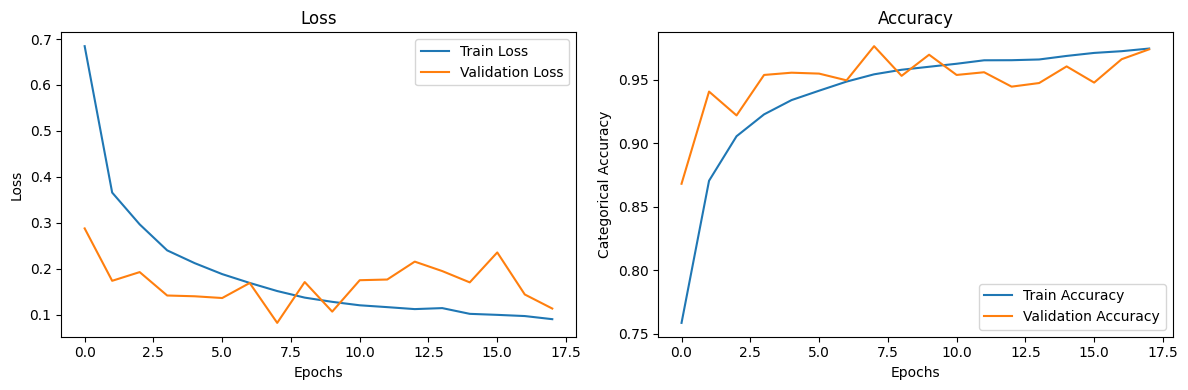

In [15]:
# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('src/training_history.png')
plt.show()

## Evaluation

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9226 - categorical_accuracy: 0.8837 - loss: 0.3688 - precision: 0.8837 - recall: 0.8837
Test Loss: 0.24848152697086334
Test Precision: 0.9172794222831726
Test Recall: 0.9172794222831726
Test AUC: 0.9641658067703247
Test Accuracy: 0.9172794222831726
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Optimal threshold: 0.19976811110973358
              precision    recall  f1-score   support

        fake       0.96      0.93      0.95       544
        real       0.93      0.96      0.95       544

    accuracy                           0.95      1088
   macro avg       0.95      0.95      0.95      1088
weighted avg       0.95      0.95      0.95      1088



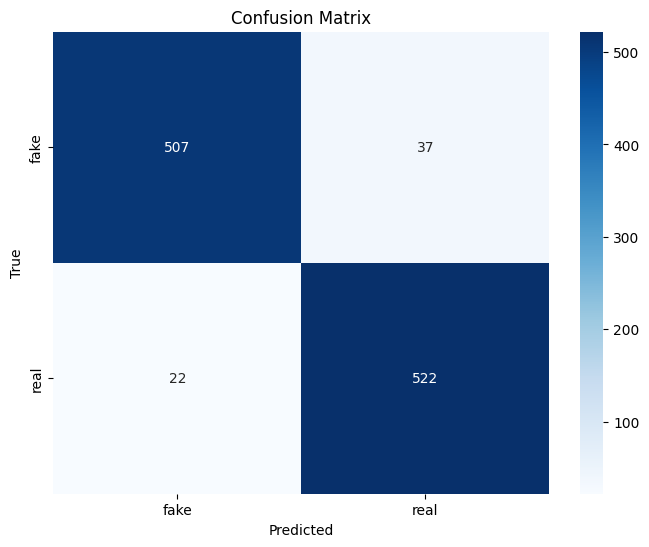

In [16]:
# Evaluating the model
test_loss, test_precision, test_recall, test_auc, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test Accuracy: {test_accuracy}")

# Computing Threshold
y_pred_probs = model.predict(X_test)[:, 1]
y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

# Generating predictions
y_pred = (y_pred_probs >= optimal_threshold).astype(int)

# Generating classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('src/confusion_matrix.png')
plt.show()

## Saving the Model

In [17]:
# Saving the model
model.save('model/final_model.keras')

# Saving the label encoder
joblib.dump(label_encoder, 'model/label_encoder.pkl')

# Saving the training history
with open('model/training_history.json', 'w') as f:
    json.dump(history.history, f)